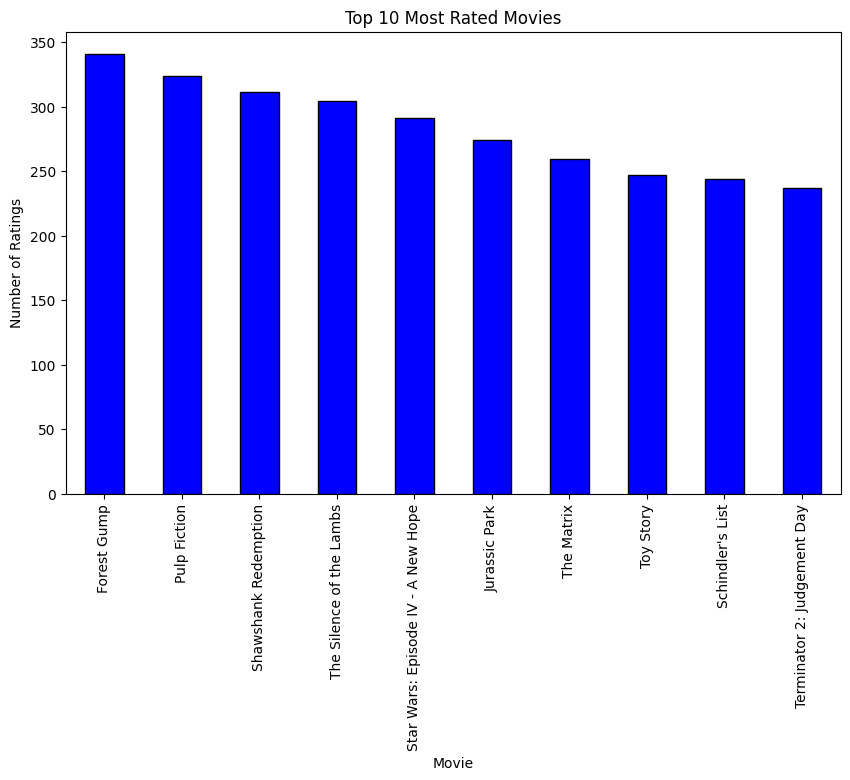

In [16]:
# To evaluate, visualize and work with the data, I need these dependencies
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse, mae
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# I set a seed so each run produces the same result everytime
# This gives me consistent results for each run.
np.random.seed(5)

# Now I extract and grab the CSV data
ratings_csv = "data/ratings_small.csv"
df = pd.read_csv(ratings_csv)

# Once I have the data, I can begin to look at deeper for more insights. 
# One of the things that would be helpful to look at, is what are the top 10 most rated movies in the dataset.
# To do that, I can group each movie in the ratings_small.csv by their movie_id. 
# There are too many movies to fit all of them on one barchart, so I limited the size of my visualization to just 10.
# Feel free to adjust 
top_movies = df.groupby("movie_id").size().sort_values(ascending=False).head(10)

# After I ran this plot the first time, I thought it'd be nicer to have the movie names in the bar chart.
# So I added this object by eye-balling the ids, looking up their imdb id and then adding their title here
movie_names = {
    356: "Forest Gump",
    296: "Pulp Fiction",
    318: "Shawshank Redemption",
    593: "The Silence of the Lambs",
    260: "Star Wars: Episode IV - A New Hope",
    480: "Jurassic Park",
    2571: "The Matrix",
    1: "Toy Story",
    527: "Schindler's List",
    589: "Terminator 2: Judgement Day",
}

# This will replace the movie ids with the movie names from above
top_movies_named = top_movies.rename(index=movie_names)

# Plotting the Bar Chart
plt.figure(figsize=(10, 6))
top_movies_named.plot(kind="bar", color="blue", edgecolor="black")
plt.title("Top 10 Most Rated Movies")
plt.xlabel("Movie")
plt.ylabel("Number of Ratings")
plt.show()

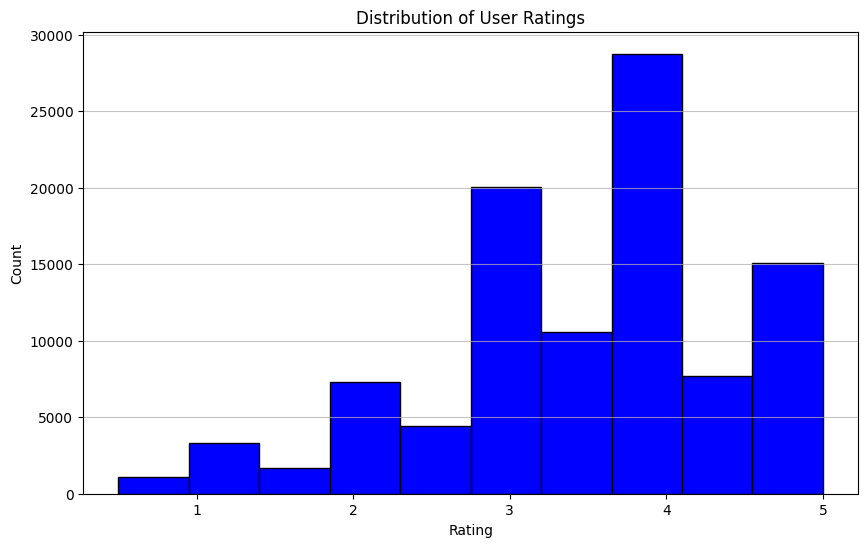

In [3]:
plt.figure(figsize=(10, 6))
df['rating'].plot(kind='hist', bins=10, color='blue', edgecolor='black')
plt.title('Distribution of User Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(range(1, 6))
plt.grid(axis='y', alpha=0.75)
plt.show()

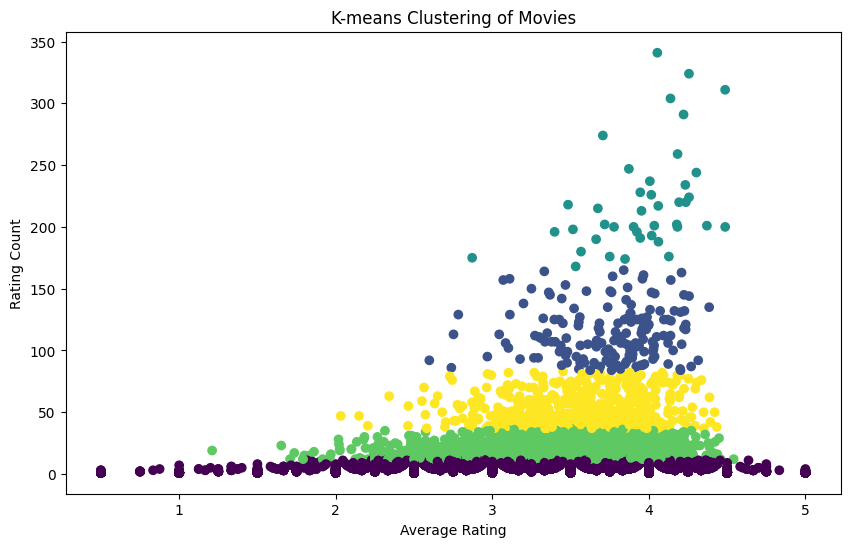

In [4]:
movie_stats = df.groupby('movie_id').agg({'rating': ['mean', 'count']})
movie_stats.columns = ['average_rating', 'rating_count']

kmeans = KMeans(n_init='auto', n_clusters=5, random_state=5)
kmeans.fit(movie_stats)
labels = kmeans.labels_

plt.figure(figsize=(10, 6))
plt.scatter(movie_stats['average_rating'], movie_stats['rating_count'], c=labels, cmap='viridis')
plt.xlabel('Average Rating')
plt.ylabel('Rating Count')
plt.title('K-means Clustering of Movies')
plt.show()

In [5]:
# To make the model churn the same results each time, I add this
np.random.seed(5)

# Now I use the Surprise library to grab the data from the CSV file. 
reader = Reader(line_format='user item rating timestamp', sep=',', rating_scale=(1, 5), skip_lines=1)
ratings_data = Dataset.load_from_file(file_path=ratings_csv, reader=reader)

# I split the data into a trainset and a testset so I can test my model for accuracy later
trainset, testset = train_test_split(ratings_data, test_size=0.25)

# I train the algorithm using the trainset
algo = SVD()
algo.fit(trainset)

# the RMSE is 0.8888 and the MAE is 0.6859
# This falls within the acceptable parameters that I set in the executive summary
# Although they are rather high, and something closer to 0.5 would've been better
predictions = algo.test(testset)
accuracy = rmse(predictions)
accuracy = mae(predictions)

RMSE: 0.8888
MAE:  0.6859


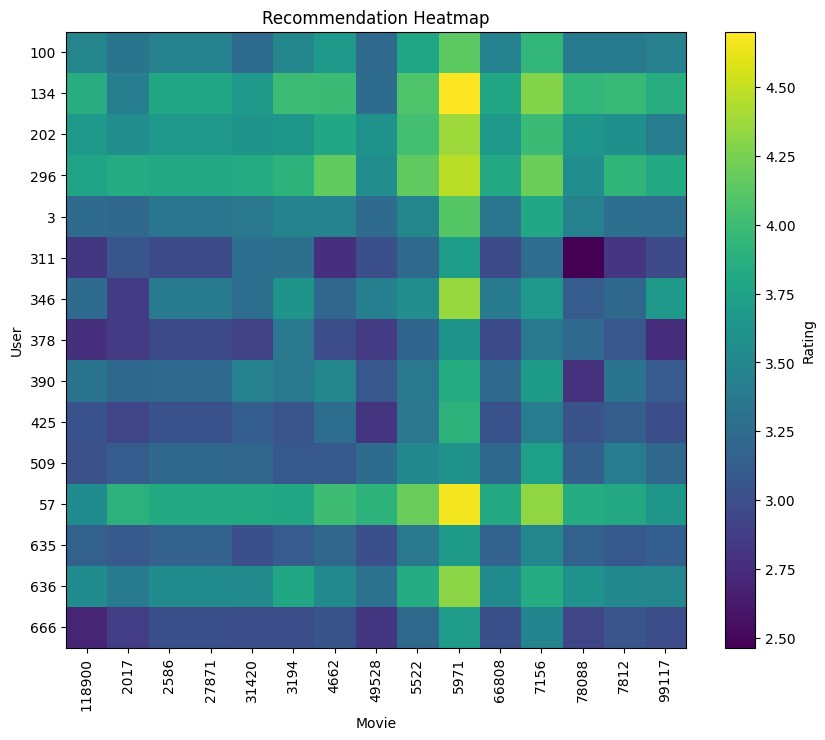

In [6]:
# Now I want to generate a visualization for my recommendation model
# I grab a subset users and movies 
users = list(set([uid for (uid, _, _) in testset]))[:15]
movies = list(set([iid for (_, iid, _) in testset]))[:15]

# Then I make a bunch of predictions for those users and movies and save that data
data = []
for user in users:
    for movie in movies:
        rating = algo.predict(user, movie).est
        data.append({"user": user, "movie": movie, "rating": rating})

# I then fit this data to a dataframe
df = pd.DataFrame(data)
pivot = df.pivot(index="user", columns="movie", values="rating")

# Now I can plot a heatmap that shows which movies are recommended for which users (out of the 15 chosen for each category)
# The brighter colors mean the model is more likely to recommend that movie to that particular user.
# User 79 looks like a hater
plt.figure(figsize=(10, 8))
plt.imshow(pivot, cmap="viridis", aspect='auto')
plt.colorbar(label='Rating')  # This line adds the colorbar
plt.title("Recommendation Heatmap")
plt.xlabel("Movie")
plt.ylabel("User")
plt.xticks(range(len(pivot.columns)), pivot.columns, rotation=90)
plt.yticks(range(len(pivot.index)), pivot.index)
plt.show()